<a href="https://colab.research.google.com/github/r0mer0/Mestrado/blob/main/Exercicio5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set tf 1.x for colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


Importando bibliotecas

In [126]:
import sys
sys.path.append("..")
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import keras_utils
from keras_utils import reset_tf_session 
import random

1.15.2
2.3.1


Funções úteis

In [7]:
IMG_SIZE = 250
s = K.get_session()


In [8]:
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

In [9]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

In [10]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [11]:
def image_center_crop(img):
    h, w, c = img.shape
    h_init=int((h-min(h,w))/2)
    w_init=int((w-min(h,w))/2)
    cropped_img = img[h_init:h_init+min(h, w),w_init:min(h,w)+w_init,:]
    
    # checks for errors
    assert cropped_img.shape == (min(h, w), min(h, w), c), "error in image_center_crop!"
    
    return cropped_img

In [12]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2021-03-23 15:48:21--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2021-03-23 15:48:22--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  11.5MB/s    in 30s     

2021-03-23 15:48:53 (11.0 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2021-03-23 15:48:54--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.

(500, 667, 3)


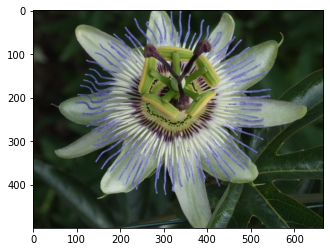

(250, 250, 3)


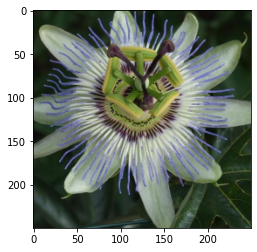

In [13]:
raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00010.jpg")
img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

In [14]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames("102flowers.tgz"))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  # read class labels (0, 1, 2, ...)
# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [15]:
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [16]:
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [17]:
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    i=0
    output = []
    for item in items:
      if(i<batch_size):
        output.append(item)
        i+=1
      if(i==batch_size):
        yield output
        i=0
        output = []
    yield output

In [18]:
def train_generator(files, labels):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_with_label_from_tar(
                "102flowers.tgz", files, labels), BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

In [19]:
def inception(use_imagenet=True):
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [20]:
model = inception()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


87916544/87910968 [==============================] - 5s 0us/step


In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 124, 124, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 124, 124, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [22]:
print(len(model.layers))

313


In [23]:
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.momentum = 0.9
    

for layer in model.layers[:-50]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [24]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adamax(lr=1e-2),  
    metrics=['accuracy'] 
)

In [25]:
model_filename = 'flowers.{0:03d}.hdf5'
last_finished_epoch = None

In [30]:

model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs=2 * 8,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[keras_utils.TqdmProgressCallback(), 
               keras_utils.ModelSaveCallback(model_filename)],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)



Epoch 1/16
**************************
loss: 4.4735; accuracy: 0.1709; val_loss: 17.2844; val_accuracy: 0.1849
Model saved in flowers.000.hdf5

Epoch 2/16
**************************
loss: 2.5399; accuracy: 0.4346; val_loss: 6.1092; val_accuracy: 0.3802
Model saved in flowers.001.hdf5

Epoch 3/16
**************************
loss: 1.5239; accuracy: 0.6241; val_loss: 2.0777; val_accuracy: 0.6172
Model saved in flowers.002.hdf5

Epoch 4/16
**************************
loss: 1.0564; accuracy: 0.7239; val_loss: 0.6484; val_accuracy: 0.7109
Model saved in flowers.003.hdf5

Epoch 5/16
**************************
loss: 0.7303; accuracy: 0.8003; val_loss: 1.5459; val_accuracy: 0.7905
Model saved in flowers.004.hdf5

Epoch 6/16
**************************
loss: 0.6587; accuracy: 0.8459; val_loss: 1.1438; val_accuracy: 0.8698
Model saved in flowers.005.hdf5

Epoch 7/16
**************************
loss: 0.5156; accuracy: 0.8940; val_loss: 0.1530; val_accuracy: 0.9219
Model saved in flowers.006.hdf5

Epo

In [131]:
np.random.choice(len(all_files))

5776

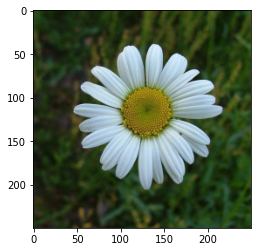

Rotulo previsto:  [48]
Rotulo real:  48


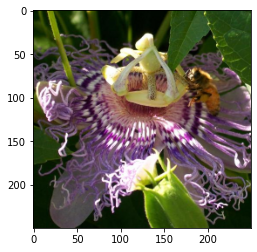

Rotulo previsto:  [76]
Rotulo real:  76


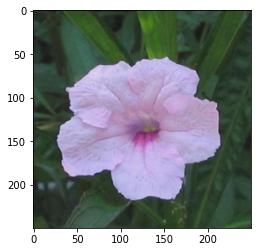

Rotulo previsto:  [97]
Rotulo real:  97


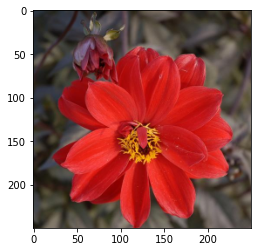

Rotulo previsto:  [55]
Rotulo real:  55


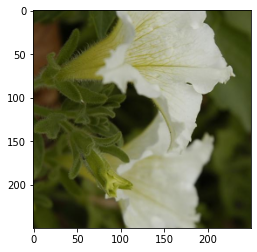

Rotulo previsto:  [50]
Rotulo real:  50


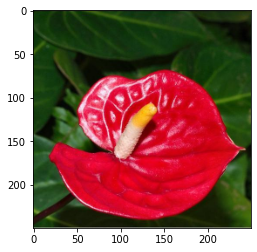

Rotulo previsto:  [79]
Rotulo real:  79


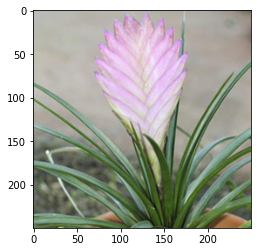

Rotulo previsto:  [92]
Rotulo real:  92


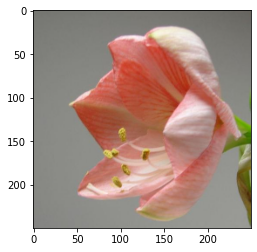

Rotulo previsto:  [90]
Rotulo real:  90


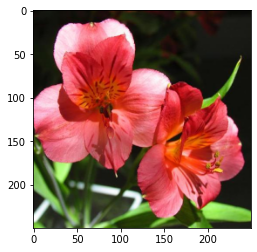

Rotulo previsto:  [17]
Rotulo real:  17


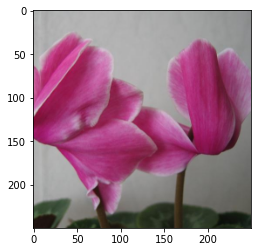

Rotulo previsto:  [87]
Rotulo real:  87


In [141]:
for i in range(10):
  pos=np.random.choice(len(all_files))
  raw_bytes = read_raw_from_tar("102flowers.tgz", all_files[pos])
  img = prepare_raw_bytes_for_model(raw_bytes)
  img_view = prepare_raw_bytes_for_model(raw_bytes,normalize_for_model=False)
  teste = model.predict(np.expand_dims(img,axis=0))
  plt.imshow(img_view)
  plt.show()
  print("Rotulo previsto: ",np.argmax(teste,axis=1))
  print("Rotulo real: ",all_labels[pos])
